## Random Forest

Random Forest is an ensemble of Decision Trees. With a few exceptions, a `RandomForestClassifier` has all the hyperparameters of a `DecisionTreeClassifier` (to control how trees are grown), plus all the hyperparameters of a `BaggingClassifier` to control the ensemble itself.

The Random Forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features. This results in a greater tree diversity, which (once again) trades a higher bias for a lower variance, generally yielding an overall better model. The following `BaggingClassifier` is roughly equivalent to the previous `RandomForestClassifier`. Run the cell below to visualize a single estimator from a random forest model, using the Iris dataset to classify the data into the appropriate species.

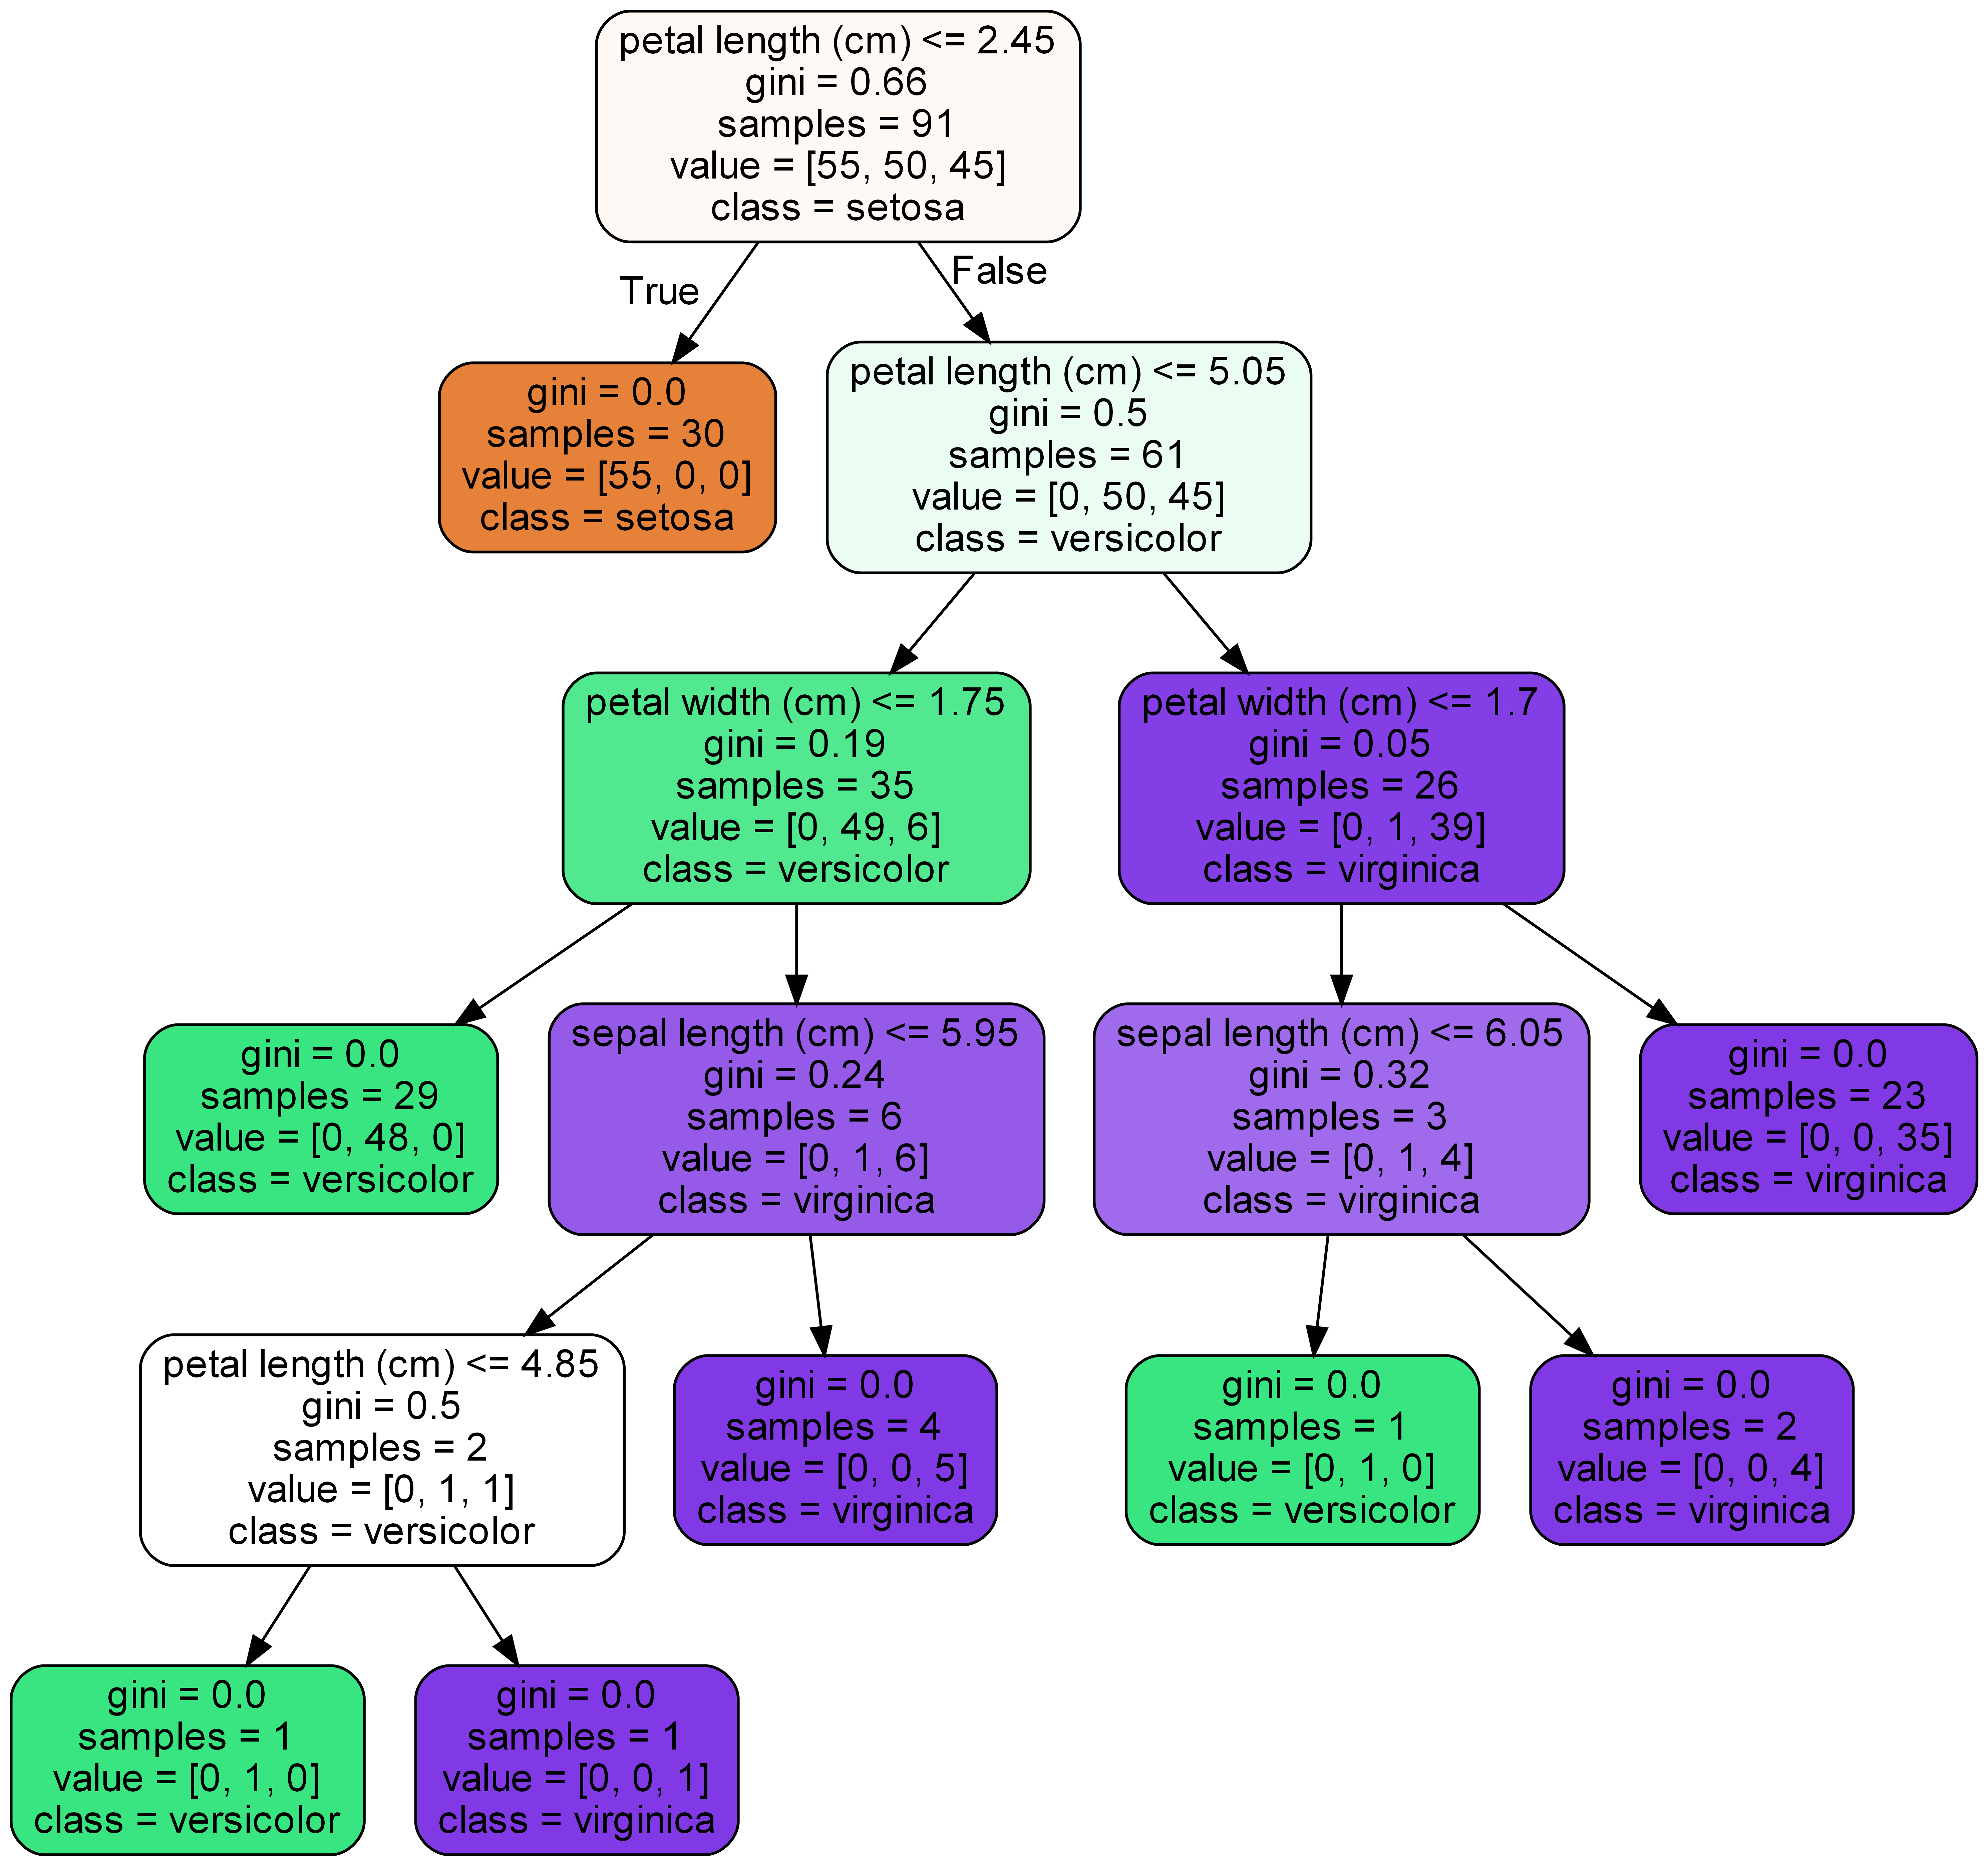

In [175]:
from sklearn.datasets import load_iris
iris = load_iris()

# Model (can also use single decision tree)
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=10)

# Train
model.fit(iris.data, iris.target)
# Extract single tree
estimator = model.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = iris.feature_names,
                class_names = iris.target_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

Notice how each split seperates the data into buckets of similar observations. This is a single tree and a relatively simple classification dataset, but the same method is used in a more complex dataset with greater depth to the trees.

## Coronavirus
Coronavirus disease (COVID-19) is an infectious disease caused by a new virus.
The disease causes respiratory illness (like the flu) with symptoms such as a cough, fever, and in more severe cases, difficulty breathing. You can protect yourself by washing your hands frequently, avoiding touching your face, and avoiding close contact (1 meter or 3 feet) with people who are unwell. An outbreak of COVID-19 started in December 2019 and at the time of the creation of this project was continuing to spread throughout the world. Many governments recommended only essential outings to public places and closed most business that do not serve food or sell essential items. An excellent [spatial dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6) built by Johns Hopkins shows the daily confirmed cases by country. 

This case study was designed to drive home the important role that data science plays in real-world situations like this pandemic. This case study uses the Random Forest Classifier and a dataset from the South Korean cases of COVID-19 provided on [Kaggle](https://www.kaggle.com/kimjihoo/coronavirusdataset) to encourage research on this important topic. The goal of the case study is to build a Random Forest Classifier to predict the 'state' of the patient.

First, please load the needed packages and modules into Python. Next, load the data into a pandas dataframe for ease of use.

In [176]:
import os
import pandas as pd
from datetime import datetime,timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import plotly.graph_objects as go
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

In [177]:
url ='SouthKoreacoronavirusdataset/PatientInfo.csv'
df = pd.read_csv(url)
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released


In [178]:
df.shape

(2218, 18)

In [179]:
#Counts of null values 
na_df=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)).reset_index()
na_df.columns = ['VarName', 'NullCount']
na_df[(na_df['NullCount']>0)]

,VarName,NullCount
0,disease,2199
1,deceased_date,2186
2,infection_order,2176
3,symptom_onset_date,2025
4,released_date,1995
5,contact_number,1807
6,infected_by,1749
7,infection_case,1055
8,global_num,904
9,birth_year,454


In [180]:
df.birth_year.describe()


count    1764.000000
mean     1974.988662
std        19.412643
min      1916.000000
25%      1962.000000
50%      1974.500000
75%      1993.000000
max      2020.000000
Name: birth_year, dtype: float64

In [181]:
#counts of response variable values
df.state.value_counts()

isolated    1791
released     307
deceased      32
Name: state, dtype: int64

 **<font color='teal'> Create a new column named 'n_age' which is the calculated age based on the birth year column.</font>**

In [182]:
df['n_age'] = datetime.now() - pd.to_datetime(df.birth_year)

### Handle Missing Values

 **<font color='teal'> Print the number of missing values by column.</font>**

In [183]:
#Counts of null values 
na_df=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)).reset_index()
na_df.columns = ['VarName', 'NullCount']
na_df[(na_df['NullCount']>0)]

,VarName,NullCount
0,disease,2199
1,deceased_date,2186
2,infection_order,2176
3,symptom_onset_date,2025
4,released_date,1995
5,contact_number,1807
6,infected_by,1749
7,infection_case,1055
8,global_num,904
9,n_age,454


 **<font color='teal'> Fill the 'disease' missing values with 0 and remap the True values to 1.</font>**

In [184]:
df.disease.value_counts()

True    19
Name: disease, dtype: int64

In [185]:
df.disease.fillna(0, inplace=True)

In [186]:
df.disease.replace(to_replace=True, value=1, inplace=True)

 **<font color='teal'> Fill null values in the following columns with their mean: 'global_number','birth_year','infection_order','infected_by'and 'contact_number'</font>**

In [187]:
df.global_num.describe()

count    1314.000000
mean     4664.816591
std      2874.044464
min         1.000000
25%      1908.500000
50%      5210.500000
75%      7481.500000
max      8717.000000
Name: global_num, dtype: float64

In [188]:
mask = df.global_num.isna()
df.global_num[mask] = df.global_num.mean()

mask = df.birth_year.isna()
df.birth_year[mask] = df.birth_year.mean()

<ipython-input-188-1b9f1609d2a6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.global_num[mask] = df.global_num.mean()
<ipython-input-188-1b9f1609d2a6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.birth_year[mask] = df.birth_year.mean()


In [189]:
df.global_num.sample(10)

83      3680.000000
1408    5603.000000
1431    6126.000000
2007    4664.816591
1395    5702.000000
2140    4664.816591
1780    4664.816591
1258    3980.000000
1407    5437.000000
657     2736.000000
Name: global_num, dtype: float64

In [190]:
mask = df.birth_year.isna()
df.birth_year[mask] = df.birth_year.mean()
df.birth_year.sample(10)

<ipython-input-190-dcd290c3576f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.birth_year[mask] = df.birth_year.mean()


535     1973.0
998     1959.0
1408    1997.0
2144    1986.0
4       1992.0
2217    1974.0
675     2007.0
375     1972.0
1627    1977.0
292     1994.0
Name: birth_year, dtype: float64

In [191]:
mask = df.infection_order	.isna()
df.infection_order	[mask] = df.infection_order	.mean()
df.infection_order	.sample(10)

<ipython-input-191-8a0d55d8ce8d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.infection_order	[mask] = df.infection_order	.mean()


1066    2.285714
1541    2.285714
1620    2.285714
876     2.285714
243     2.285714
197     2.285714
1148    2.285714
1136    2.285714
272     2.285714
1013    2.285714
Name: infection_order, dtype: float64

In [192]:
mask = df.infected_by	.isna()
df.infected_by	[mask] = df.infected_by	.mean()
df.infected_by	.sample(10)

<ipython-input-192-c932db8372b1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.infected_by	[mask] = df.infected_by	.mean()


1843    2.600789e+09
167     2.600789e+09
2169    6.106000e+09
536     2.600789e+09
2146    2.600789e+09
836     2.000000e+09
2159    2.600789e+09
990     4.100000e+09
142     2.600789e+09
626     2.600789e+09
Name: infected_by, dtype: float64

In [193]:
mask = df.contact_number.isna()
df.contact_number[mask] = df.contact_number.mean()
df.contact_number.sample(10)

<ipython-input-193-955d4093bd10>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.contact_number[mask] = df.contact_number.mean()


1580    24.128954
772     24.128954
967      5.000000
1870    24.128954
1506    24.128954
1855    24.128954
583     23.000000
1027    14.000000
97      24.128954
1585    24.128954
Name: contact_number, dtype: float64

 **<font color='teal'> Fill the rest of the missing values with any method.</font>**

In [194]:
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,0,overseas inflow,1.0,2.600789e+09,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released,18926 days 15:56:32.864373036
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,0,overseas inflow,1.0,2.600789e+09,31.0,NaN,2020-01-30,2020-03-02,NaN,released,18926 days 15:56:32.864373013
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,0,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released,18926 days 15:56:32.864373036
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,0,overseas inflow,1.0,2.600789e+09,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released,18926 days 15:56:32.864373009
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,0,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released,18926 days 15:56:32.864373008


 **<font color='teal'> Check for any remaining null values.</font>**

In [195]:
df.deceased_date.sample(10)

1007    NaN
1454    NaN
698     NaN
1649    NaN
1192    NaN
644     NaN
61      NaN
673     NaN
909     NaN
887     NaN
Name: deceased_date, dtype: object

In [196]:
#Counts of null values 
na_df=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)).reset_index()
na_df.columns = ['VarName', 'NullCount']
na_df[(na_df['NullCount']>0)]

,VarName,NullCount
0,deceased_date,2186
1,symptom_onset_date,2025
2,released_date,1995
3,infection_case,1055
4,n_age,454
5,age,261
6,sex,145
7,confirmed_date,141
8,state,88
9,city,65


In [197]:
# Second fill in, now that we've imputed the birth date for a bunch of folks
df['n_age'] = datetime.now() - pd.to_datetime(df.birth_year)

In [198]:
df.infection_case.value_counts()

contact with patient                530
etc                                 220
Guro-gu Call Center                 102
Shincheonji Church                   86
overseas inflow                      61
Onchun Church                        33
gym facility in Cheonan              30
Ministry of Oceans and Fisheries     27
Cheongdo Daenam Hospital             21
Dongan Church                        17
Eunpyeong St. Mary's Hospital        14
Seongdong-gu APT                     13
gym facility in Sejong                4
Suyeong-gu Kindergarten               3
River of Grace Community Church       1
Pilgrimage to Israel                  1
Name: infection_case, dtype: int64

In [199]:
mask = df.infection_case.isna()
df.infection_case[mask] = 'unknown'
df.infection_case.value_counts()

<ipython-input-199-1240d4bcbc05>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.infection_case[mask] = 'unknown'


unknown                             1055
contact with patient                 530
etc                                  220
Guro-gu Call Center                  102
Shincheonji Church                    86
overseas inflow                       61
Onchun Church                         33
gym facility in Cheonan               30
Ministry of Oceans and Fisheries      27
Cheongdo Daenam Hospital              21
Dongan Church                         17
Eunpyeong St. Mary's Hospital         14
Seongdong-gu APT                      13
gym facility in Sejong                 4
Suyeong-gu Kindergarten                3
River of Grace Community Church        1
Pilgrimage to Israel                   1
Name: infection_case, dtype: int64

In [200]:
df.age.value_counts()

20s     467
50s     385
40s     303
30s     251
60s     229
70s     117
80s      84
10s      74
0s       29
90s      17
100s      1
Name: age, dtype: int64

In [201]:
df.birth_year.value_counts()

1974.988662    454
1969.000000     54
1995.000000     51
1998.000000     47
1999.000000     45
              ... 
2019.000000      2
1928.000000      2
1925.000000      1
1916.000000      1
1931.000000      1
Name: birth_year, Length: 97, dtype: int64

In [202]:
df.age.isna().count()

2218

In [203]:
conditons = [df.birth_year > 2011, 
            df.birth_year >  2001,
            df.birth_year >  1991,
            df.birth_year >  1981,
            df.birth_year >  1971,
            df.birth_year >  1961,
            df.birth_year >  1951,
            df.birth_year >  1941,
            df.birth_year >  1931,
            df.birth_year >  1921,
            df.birth_year >  1911,]

choices = ['0s', '10s', '20s', '30s', '40s', '50s', '60s', '70s', '80s', '90s', '100s']
mask = df.age.isna()
df.age[mask] = np.select(conditons, choices, default='100s')
print(df.age.isna().sum())

0


<ipython-input-203-b8b998113109>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.age[mask] = np.select(conditons, choices, default='100s')


In [204]:
print(df.sex.value_counts())
print(df.sex.isna().sum())

female    1171
male       902
Name: sex, dtype: int64
145


In [205]:
mask = df.sex.isna()
df.sex[mask] = np.random.choice(['female', 'male'])
print(df.sex.value_counts())
print(df.sex.isna().sum())

female    1171
male      1047
Name: sex, dtype: int64
0


<ipython-input-205-0269c91c8af5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sex[mask] = np.random.choice(['female', 'male'])


In [206]:
print(df.city.isna().sum())
df.city.value_counts()

65


Gyeongsan-si    535
Cheonan-si       98
Seongnam-si      89
Bonghwa-gun      60
Gumi-si          59
               ... 
Suncheon-si       1
Danyang-gun       1
Hamyang-gun       1
Wuhan             1
Anseong-si        1
Name: city, Length: 134, dtype: int64

In [207]:
mask = df.city.isna()
df.city[mask] = 'Unknown'
print(df.city.isna().sum())

<ipython-input-207-4d5711b2c5d3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.city[mask] = 'Unknown'


0


In [208]:
print(df.state.isna().sum())
df.state.value_counts()

88


isolated    1791
released     307
deceased      32
Name: state, dtype: int64

In [209]:
mask = df.state.isna()
df.state[mask] = 'Unknown'
print(df.state.isna().sum())
df.state.value_counts()

0


<ipython-input-209-395f0393248b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.state[mask] = 'Unknown'


isolated    1791
released     307
Unknown       88
deceased      32
Name: state, dtype: int64

In [210]:
#Counts of null values 
na_df=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)).reset_index()
na_df.columns = ['VarName', 'NullCount']
na_df[(na_df['NullCount']>0)]

,VarName,NullCount
0,deceased_date,2186
1,symptom_onset_date,2025
2,released_date,1995
3,confirmed_date,141


Remove date columns from the data.


In [211]:
y =  df[['symptom_onset_date','confirmed_date','released_date','deceased_date']]
df = df.drop(['symptom_onset_date','confirmed_date','released_date','deceased_date'],axis =1)

In [214]:
y.columns

Index(['symptom_onset_date', 'confirmed_date', 'released_date',
       'deceased_date'],
      dtype='object')

Review the count of unique values by column.

In [215]:
print(df.nunique())

patient_id         2218
global_num         1304
sex                   2
birth_year           97
age                  11
country               4
province             17
city                135
disease               2
infection_case       17
infection_order       7
infected_by         207
contact_number       73
state                 4
n_age                96
dtype: int64


Review the percent of unique values by column.

In [216]:
print(df.nunique()/df.shape[0])

patient_id         1.000000
global_num         0.587917
sex                0.000902
birth_year         0.043733
age                0.004959
country            0.001803
province           0.007665
city               0.060866
disease            0.000902
infection_case     0.007665
infection_order    0.003156
infected_by        0.093327
contact_number     0.032913
state              0.001803
n_age              0.043282
dtype: float64


Review the range of values per column.

In [217]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
patient_id,2218.0,4014678094.545085,2192418596.137527,1000000001.0,1700000007.250000,6001000034.500000,6004000027.750000,7000000004.0
global_num,2218.0,4664.816591,2211.785463,1.0,4205.250000,4664.816591,5900.250000,8717.0
birth_year,2218.0,1974.988662,17.311232,1916.0,1965.000000,1974.988662,1988.000000,2020.0
disease,2218.0,0.008566,0.092178,0.0,0.000000,0.000000,0.000000,1.0
infection_order,2218.0,2.285714,0.170662,1.0,2.285714,2.285714,2.285714,6.0
infected_by,2218.0,2600788987.586354,721632772.669963,1000000002.0,2600788987.586354,2600788987.586354,2600788987.586354,6113000028.0
contact_number,2218.0,24.128954,39.171414,0.0,24.128954,24.128954,24.128954,1160.0
n_age,2218,18926 days 15:56:33.224240128,0 days 00:00:00.000000053,18926 days 15:56:33.224239980,18926 days 15:56:33.224240128,18926 days 15:56:33.224240128,18926 days 15:56:33.224240128,18926 days 15:56:33.224240084


### Check for duplicated rows

In [218]:
duplicateRowsDF = df[df.duplicated()]
duplicateRowsDF

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,state,n_age


Print the categorical columns and their associated levels.

In [219]:
dfo = df.select_dtypes(include=['object'], exclude=['datetime'])
dfo.shape
#get levels for all variables
vn = pd.DataFrame(dfo.nunique()).reset_index()
vn.columns = ['VarName', 'LevelsCount']
vn.sort_values(by='LevelsCount', ascending =False)
vn

,VarName,LevelsCount
0,sex,2
1,age,11
2,country,4
3,province,17
4,city,135
5,infection_case,17
6,state,4


**<font color='teal'> Plot the correlation heat map for the features.</font>**

<AxesSubplot:>

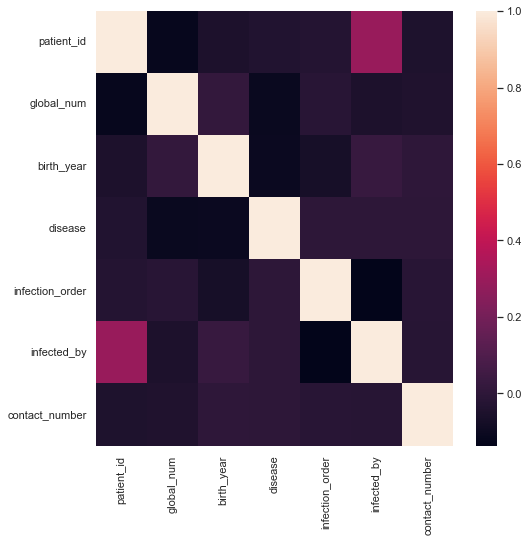

In [220]:
sns.set(rc={'axes.facecolor':'cornflowerblue', 'figure.facecolor':'white'})
plt.figure(figsize=(8,8))
sns.heatmap(df.corr())

**<font color='teal'> Plot the boxplots to check for outliers. </font>**

In [221]:
df.columns

Index(['patient_id', 'global_num', 'sex', 'birth_year', 'age', 'country',
       'province', 'city', 'disease', 'infection_case', 'infection_order',
       'infected_by', 'contact_number', 'state', 'n_age'],
      dtype='object')

{'whiskers': [<matplotlib.lines.Line2D at 0x23ed4f84dc0>,
 'caps': [<matplotlib.lines.Line2D at 0x23ed50274c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x23ed4f84b50>],
 'medians': [<matplotlib.lines.Line2D at 0x23ed5027b80>],
 'fliers': [<matplotlib.lines.Line2D at 0x23ed5027ee0>],
 'means': []}

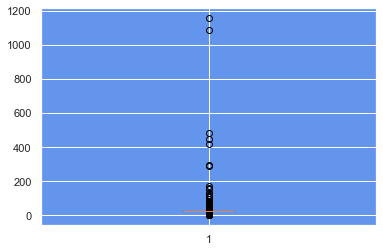

In [222]:
#The only one with a max that makes me suspicious is contact number
plt.boxplot(df.contact_number)

In [223]:
# I see the outlier, but I'm not sure I can rule it out entirely. This person could have walked through the airport twice and had that many contacts.

**<font color='teal'> Create dummy features for object type features. </font>**

In [231]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype          
---  ------           --------------  -----          
 0   patient_id       2218 non-null   int64          
 1   global_num       2218 non-null   float64        
 2   sex              2218 non-null   object         
 3   birth_year       2218 non-null   float64        
 4   age              2218 non-null   object         
 5   country          2218 non-null   object         
 6   province         2218 non-null   object         
 7   city             2218 non-null   object         
 8   disease          2218 non-null   int64          
 9   infection_case   2218 non-null   object         
 10  infection_order  2218 non-null   float64        
 11  infected_by      2218 non-null   float64        
 12  contact_number   2218 non-null   float64        
 13  state            2218 non-null   object         
 14  n_age            2218 no

In [245]:
dummy_thicc = pd.get_dummies(df.drop(['n_age', 'state'], axis=1))

In [246]:
dummy_thicc.columns

Index(['patient_id', 'global_num', 'birth_year', 'disease', 'infection_order',
       'infected_by', 'contact_number', 'sex_female', 'sex_male', 'age_0s',
       ...
       'infection_case_River of Grace Community Church',
       'infection_case_Seongdong-gu APT', 'infection_case_Shincheonji Church',
       'infection_case_Suyeong-gu Kindergarten',
       'infection_case_contact with patient', 'infection_case_etc',
       'infection_case_gym facility in Cheonan',
       'infection_case_gym facility in Sejong',
       'infection_case_overseas inflow', 'infection_case_unknown'],
      dtype='object', length=193)

### Split the data into test and train subsamples

In [247]:
from sklearn.model_selection import train_test_split
y= df.state
X = dummy_thicc
# dont forget to define your X and y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

### Scale data to prep for model creation

In [248]:
#scale data
from sklearn import preprocessing
import numpy as np
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [249]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from matplotlib import pyplot

### Fit Random Forest Classifier
The fit model shows an overall accuracy of 80% which is great and indicates our model was effectively able to identify the status of a patients in the South Korea dataset.

In [250]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

Random Forest: Accuracy=0.851
Random Forest: f1-score=0.819


### Create Confusion Matrix Plots
Confusion matrices are great ways to review your model performance for a multi-class classification problem. Being able to identify which class the misclassified observations end up in is a great way to determine if you need to build additional features to improve your overall model. In the example below we plot a regular counts confusion matrix as well as a weighted percent confusion matrix. The percent confusion matrix is particulary helpful when you have unbalanced class sizes.

In [251]:
class_names=['isolated','released','missing','deceased'] # name  of classes

Confusion matrix, without normalization
[[ 15   0   2   0]
 [  0   6   1   0]
 [  0   0 343   8]
 [  0   0  55  14]]
Normalized confusion matrix
[[0.88 0.   0.12 0.  ]
 [0.   0.86 0.14 0.  ]
 [0.   0.   0.98 0.02]
 [0.   0.   0.8  0.2 ]]


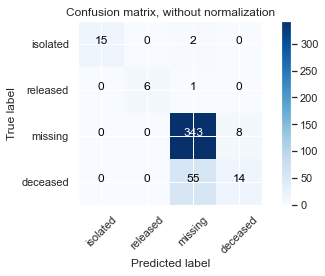

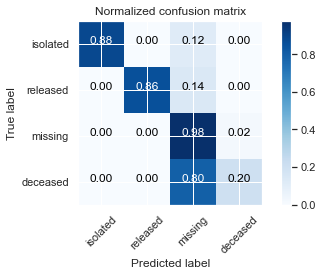

In [252]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

### Plot feature importances
The random forest algorithm can be used as a regression or classification model. In either case it tends to be a bit of a black box, where understanding what's happening under the hood can be difficult. Plotting the feature importances is one way that you can gain a perspective on which features are driving the model predictions.

30


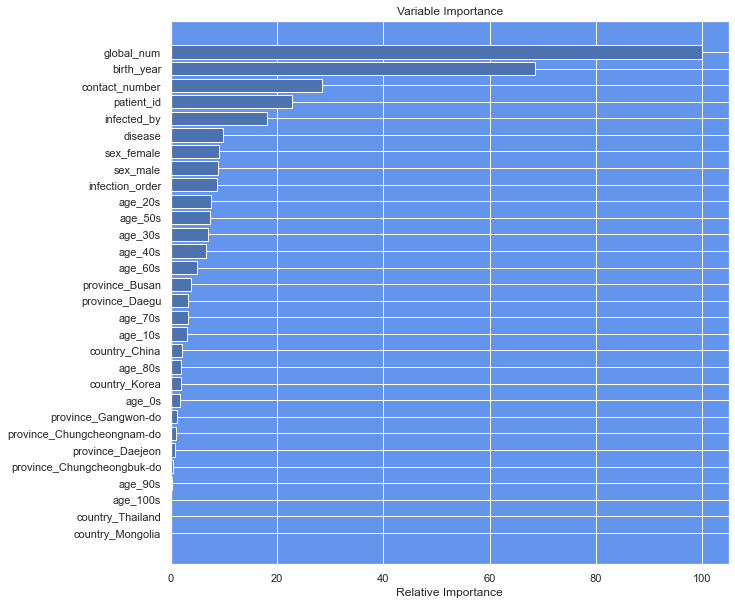

In [253]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

The popularity of random forest is primarily due to how well it performs in a multitude of data situations. It tends to handle highly correlated features well, where as a linear regression model would not. In this case study we demonstrate the performance ability even with only a few features and almost all of them being highly correlated with each other.
Random Forest is also used as an efficient way to investigate the importance of a set of features with a large data set. Consider random forest to be one of your first choices when building a decision tree, especially for multiclass classifications.